# Predicting usefulness of reviews using sklearn's Random Forest Classifier and Neural Network

In [2]:
import pandas as pd
import numpy as np

In [3]:
with open("../data/ReviewPrediction/dataset_stars.csv") as f:
    df = pd.read_csv(f, index_col=0)

# rename sum column to mapping
df.rename(columns={"sum": "mapping"}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,_id,review,score,upvotes,downvotes,mapping
0,5a5b6dfbaf6c59001a536aeb,interessantes aber sehr aufwändiges Fach. Die ...,3,0.0,1.0,1
1,5a5b70abaf6c59001a536b07,Warum wird Moodle Verwendet & nicht OLAT? Anso...,4,4.0,8.0,1
2,5a5b729faf6c59001a536b13,"langwiilig, Management teil nutzlos, nur uswän...",2,0.0,1.0,1
3,5a5b7ae5af6c59001a536b80,In diesem Fach zeichnet man Flowcharts und Pro...,3,0.0,0.0,1
4,5a5b7d07af6c59001a536b87,weiss nöd warum so viel klaget. de dozent isch...,5,1.0,0.0,2
...,...,...,...,...,...,...
9477,6318e504e3b1d00021a54004,"Sehr schwierig, wenn Sie nichts über Fotografi...",2,0.0,0.0,1
9478,6323dee79e3a200021c9d930,"Sehr interessanter Kurs, der einige sehr wicht...",5,0.0,0.0,1
9479,633da31e15d83c0021cf43f3,"Wirklich, verdammt langweilig...",2,0.0,0.0,1
9480,6356696e05897c00219dfe03,Gute Einführung in die Programmierung in Pytho...,3,0.0,0.0,1


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier

/home/liamt/Uni/Master/HS23/EITASP/Essentials-in-Text-and-Speech-Processing/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(df["review"], convert_to_tensor=True)

In [6]:
embeddings

tensor([[-0.0139,  0.0746, -0.0477,  ...,  0.0395,  0.0077,  0.0743],
        [-0.0789,  0.0889, -0.0882,  ..., -0.0345, -0.0710,  0.0214],
        [-0.0381,  0.0777,  0.0177,  ..., -0.0608, -0.0081,  0.0069],
        ...,
        [ 0.0306,  0.0836,  0.0772,  ...,  0.0274,  0.0549,  0.0237],
        [-0.0185,  0.0295, -0.1379,  ...,  0.0925,  0.0568,  0.0078],
        [-0.0229,  0.0254, -0.0353,  ..., -0.0431, -0.0187,  0.0298]])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df["mapping"], test_size=0.2, random_state=42
)

In [7]:
X_train_numpy = X_train.cpu().numpy()
y_train_numpy = y_train.to_numpy()

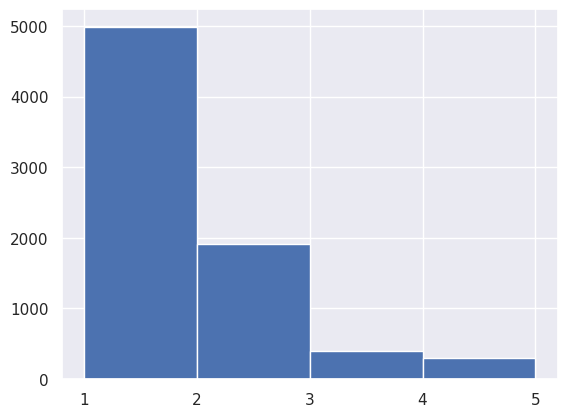

In [11]:
sns.set_theme()
plt.rcParams["font.size"] = 10
plt.hist(y_train_numpy, bins=[1, 2, 3, 4, 5])
plt.xticks(range(1, 6))

plt.show()

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_numpy, y_train_numpy)

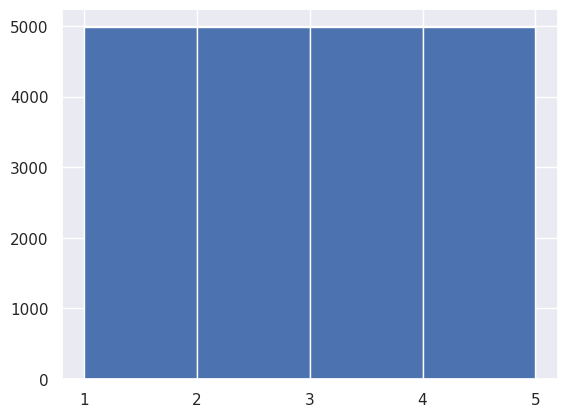

In [13]:
plt.hist(y_train_smote, bins=[1, 2, 3, 4, 5])
plt.xticks(range(1, 6))

plt.show()

In [14]:
import torch

X_train_smote_tensor = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_smote_tensor = torch.tensor(y_train_smote, dtype=torch.long)

In [55]:
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_smote_tensor, y_train_smote_tensor)

RandomForestClassifier(random_state=42)

In [56]:
y_pred = clf.predict(X_test)

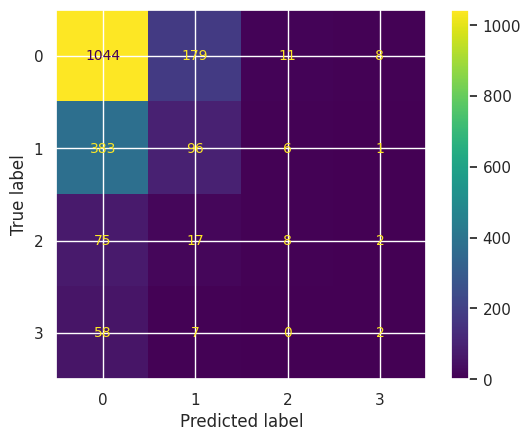

In [60]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

conf_mat = confusion_matrix(y_test, y_pred)
conf_disp = ConfusionMatrixDisplay(conf_mat)
conf_disp.plot()
plt.show()

In [59]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         1.0     0.6692    0.8406    0.7452      1242
         2.0     0.3211    0.1975    0.2446       486
         3.0     0.3200    0.0784    0.1260       102
         4.0     0.1538    0.0299    0.0500        67

    accuracy                         0.6062      1897
   macro avg     0.3660    0.2866    0.2914      1897
weighted avg     0.5431    0.6062    0.5591      1897



In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Initialize and train MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 50),
                    max_iter=300, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Evaluate on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.73      0.71      1242
           2       0.30      0.27      0.28       486
           3       0.17      0.10      0.12       102
           4       0.09      0.09      0.09        67

    accuracy                           0.56      1897
   macro avg       0.31      0.30      0.30      1897
weighted avg       0.53      0.56      0.54      1897



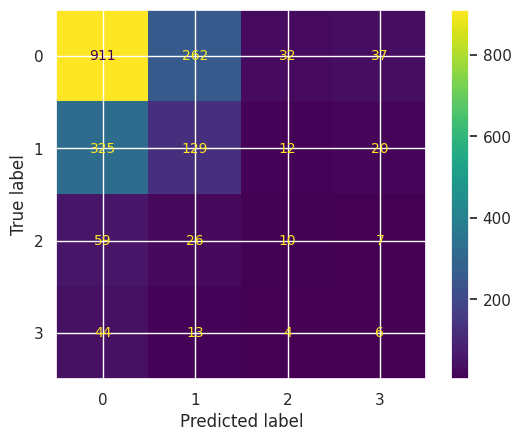

In [17]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

conf_mat = confusion_matrix(y_test, y_pred)
conf_disp = ConfusionMatrixDisplay(conf_mat)
conf_disp.plot()
plt.show()